In [30]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adagrad
import keras
# Conv1D + LSTM
# Adagrad
#Conv1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from keras.layers import Flatten

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
df_dk=pd.read_csv('/content/drive/MyDrive/RESEARCH_VANSHIKA/IoT_Conference_Paper/Data2.csv')
df_dk.head(5)

,frame.time_delta,frame.time_relative,frame.len,tcp.srcport,tcp.dstport,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,...,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,class,label
0,0.0,5.728385,54,54562,1883,0.0,0,445,0,0,...,0,0,0.0,0,0,0,6,64,Attack,1
1,0.0,5.752061,54,54562,1883,0.0,0,485,0,0,...,0,0,0.0,0,0,0,6,64,Attack,1
2,0.0,5.752335,54,54562,1883,0.0,0,505,0,0,...,0,0,0.0,0,0,0,6,64,Attack,1
3,0.0,5.752947,54,54562,1883,0.0,0,525,0,0,...,0,0,0.0,0,0,0,6,64,Attack,1
4,0.0,6.096030,54,54562,1883,0.0,0,1181,0,0,...,0,0,0.0,0,0,0,6,64,Attack,1


In [33]:
col_list = ["frame.time_delta",	"frame.time_relative",	"frame.len"	,
            "tcp.time_delta",	"tcp.len",	"tcp.ack",	"tcp.connection.fin",	"tcp.connection.rst",	"tcp.connection.sack",
            "tcp.connection.syn",	"tcp.flags.ack",	"tcp.flags.fin",	"tcp.flags.push",	"tcp.flags.reset",	"tcp.flags.syn",
            "tcp.flags.urg",	"tcp.hdr_len",	"tcp.pdu.size",	"tcp.window_size_value",
            "mqtt.clientid_len",	"mqtt.conack.val",	"mqtt.conflag.passwd",	"mqtt.conflag.qos",	"mqtt.conflag.reserved",
            "mqtt.conflag.retain",	"mqtt.conflag.willflag",
            "mqtt.dupflag",		"mqtt.kalive",	"mqtt.len",	"mqtt.msg",	"mqtt.msgtype",	"mqtt.qos",	"mqtt.retain",
            "mqtt.topic",
            "mqtt.topic_len",	"mqtt.ver",	"mqtt.willmsg_len",	"ip.proto",	"ip.ttl",	"class",	"label"

           ]

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics
cat_features = ['class']
encoder = LabelEncoder()
label_encoder = preprocessing.LabelEncoder()
for feature in cat_features:
    encoded = label_encoder.fit_transform(df_dk[cat_features])
    df_dk['class'] = encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
len(df_dk)

188694

In [36]:
df_dk.dtypes

frame.time_delta         float64
frame.time_relative      float64
frame.len                  int64
tcp.srcport                int64
tcp.dstport                int64
tcp.time_delta           float64
tcp.len                    int64
tcp.ack                    int64
tcp.connection.fin         int64
tcp.connection.rst         int64
tcp.connection.sack        int64
tcp.connection.syn         int64
tcp.flags.ack              int64
tcp.flags.fin              int64
tcp.flags.push             int64
tcp.flags.reset            int64
tcp.flags.syn              int64
tcp.flags.urg              int64
tcp.hdr_len                int64
tcp.pdu.size               int64
tcp.window_size_value      int64
mqtt.clientid_len          int64
mqtt.conack.val            int64
mqtt.conflag.passwd        int64
mqtt.conflag.qos           int64
mqtt.conflag.reserved      int64
mqtt.conflag.retain        int64
mqtt.conflag.willflag      int64
mqtt.dupflag               int64
mqtt.kalive                int64
mqtt.len  

In [37]:
print(df_dk.isna().sum().sum())
df_dk=df_dk.dropna()
print(df_dk.isna().sum().sum())

142272
0


In [38]:
df_dk.sample(5)

,frame.time_delta,frame.time_relative,frame.len,tcp.srcport,tcp.dstport,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,...,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,class,label
15730,0.000030,131.450585,54,50940,1883,0.000030,0,5,0,0,...,0,0,0.0,0,0,0,6,64,0,1
151617,0.000002,3.419253,60,1883,54547,0.000002,0,12876,0,0,...,0,0,0.0,0,0,0,6,128,0,1
12060,0.000100,71.927587,54,49462,1883,0.000105,0,1,0,0,...,0,0,0.0,0,0,0,6,64,0,1
39857,0.000022,660.319076,70,46179,1883,4.496772,2,25,0,0,...,0,0,0.0,0,0,0,6,64,1,0
45782,0.000004,0.186106,95,57140,1883,0.057732,29,1,0,0,...,0,0,0.0,0,0,0,6,64,0,1


In [39]:
df_dk.groupby('label').size()

label
0    19232
1    53561
dtype: int64

In [40]:
for col in (df_dk.iloc[:,:-1].columns):
    if(df_dk[col].min()==df_dk[col].max()):
            df_dk.drop(col, axis=1, inplace=True)

In [41]:
# Normalization OR Standardization
def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/(df[col].std()) # Standardization
    #df[col]= (df[col]-df[col].min())/(df[col].max()-df[col].min()) #Normalization

for i in (df_dk.iloc[:,:-1].columns):
    standardize (df_dk,i)

df_dk.head()

,frame.time_delta,frame.time_relative,frame.len,tcp.srcport,tcp.dstport,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,...,tcp.pdu.size,tcp.window_size_value,mqtt.clientid_len,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.ver,ip.ttl,class,label
0,-0.032272,-0.446647,-0.488833,1.241355,-1.121817,-0.185499,-0.262305,-0.491864,-0.112701,-0.151486,...,-0.173083,0.009637,-0.042115,-0.119078,-0.10662,-0.815009,-0.16691,-0.696107,-0.556621,1
1,-0.032272,-0.446626,-0.488833,1.241355,-1.121817,-0.185499,-0.262305,-0.491746,-0.112701,-0.151486,...,-0.173083,0.010000,-0.042115,-0.119078,-0.10662,-0.815009,-0.16691,-0.696107,-0.556621,1
2,-0.032272,-0.446626,-0.488833,1.241355,-1.121817,-0.185499,-0.262305,-0.491687,-0.112701,-0.151486,...,-0.173083,0.010000,-0.042115,-0.119078,-0.10662,-0.815009,-0.16691,-0.696107,-0.556621,1
3,-0.032272,-0.446625,-0.488833,1.241355,-1.121817,-0.185499,-0.262305,-0.491629,-0.112701,-0.151486,...,-0.173083,0.010000,-0.042115,-0.119078,-0.10662,-0.815009,-0.16691,-0.696107,-0.556621,1
4,-0.032272,-0.446326,-0.488833,1.241355,-1.121817,-0.185499,-0.262305,-0.489702,-0.112701,-0.151486,...,-0.173083,0.010000,-0.042115,-0.119078,-0.10662,-0.815009,-0.16691,-0.696107,-0.556621,1


In [42]:
target=['label']
features = [c for c in df_dk.columns if c!="label"]

In [43]:
X = df_dk[features].values # Features
y = df_dk[target].values # Target

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((72793, 27), (72793, 1))

In [44]:
del df_dk

In [45]:
gc.collect()

906

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [47]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((58234, 27), (14559, 27), (58234, 1), (14559, 1))

In [48]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
print(X_train_cnn.shape)
print(X_test_cnn.shape)


(58234, 27, 1)
(14559, 27, 1)


In [49]:
learning_rate=0.001
batch_size=5000
epochs = 10

model_save = ModelCheckpoint('./finalmodel1IoTHC.h5',
                             save_best_only = True,
                             save_weights_only = True,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001,
                           patience = 8, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.6,
                              patience = 4, min_delta = 0.0001,
                              mode = 'min', verbose = 1)

In [50]:
X_test.shape[1]

27

In [51]:
model = Sequential()
model.add(Conv1D(16,2,input_shape = (X_test.shape[1], 1)))
model.add(Conv1D(16,2))
model.add(MaxPooling1D(1))


model.add(Conv1D(32,2))
model.add(Conv1D(32,2))
model.add(MaxPooling1D(1))

model.add(Conv1D(64,2))
model.add(Conv1D(64,2))
model.add(MaxPooling1D(1))

model.add(Conv1D(128,2))
model.add(Conv1D(128,2))
model.add(MaxPooling1D(1))

#model.add(LSTM(32, activation = 'relu', return_sequences=True))
#model.add(LSTM(16, return_sequences=True))  # returns a sequence of vectors of dimension 16
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(1,activation='sigmoid'))
optimizer = Adagrad(learning_rate=learning_rate)
#model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=[keras.metrics.AUC(name='auc')])


history = model.fit(X_train_cnn,
                    y_train,
                    batch_size=batch_size,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test_cnn,y_test),
                    callbacks = [model_save, early_stop, reduce_lr],)

Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 0.6466 - auc: 0.9029
Epoch 1: val_loss improved from inf to 0.62523, saving model to ./finalmodel1IoTHC.h5
11/11 [==============================] - 25s 2s/step - loss: 0.6466 - auc: 0.9029 - val_loss: 0.6252 - val_auc: 0.9700 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 0.6148 - auc: 0.9485
Epoch 2: val_loss improved from 0.62523 to 0.59328, saving model to ./finalmodel1IoTHC.h5
11/11 [==============================] - 21s 2s/step - loss: 0.6148 - auc: 0.9485 - val_loss: 0.5933 - val_auc: 0.9736 - lr: 0.0010
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 0.5853 - auc: 0.9667
Epoch 3: val_loss improved from 0.59328 to 0.56198, saving model to ./finalmodel1IoTHC.h5
11/11 [==============================] - 20s 2s/step - loss: 0.5853 - auc: 0.9667 - val_loss: 0.5620 - val_auc: 0.9881 - lr: 0.0010
Epoch 4/10
11/11 [==============================] - ETA: 0s - loss: 0.5

In [52]:
y_pred = model.predict(X_test_cnn, batch_size=512)
AUC = metrics.roc_auc_score(y_test,y_pred)
print("AUC: {:.3f}".format(AUC))

29/29 [==============================] - 1s 38ms/step
AUC: 1.000


In [54]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('finalmodel1.csv')

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

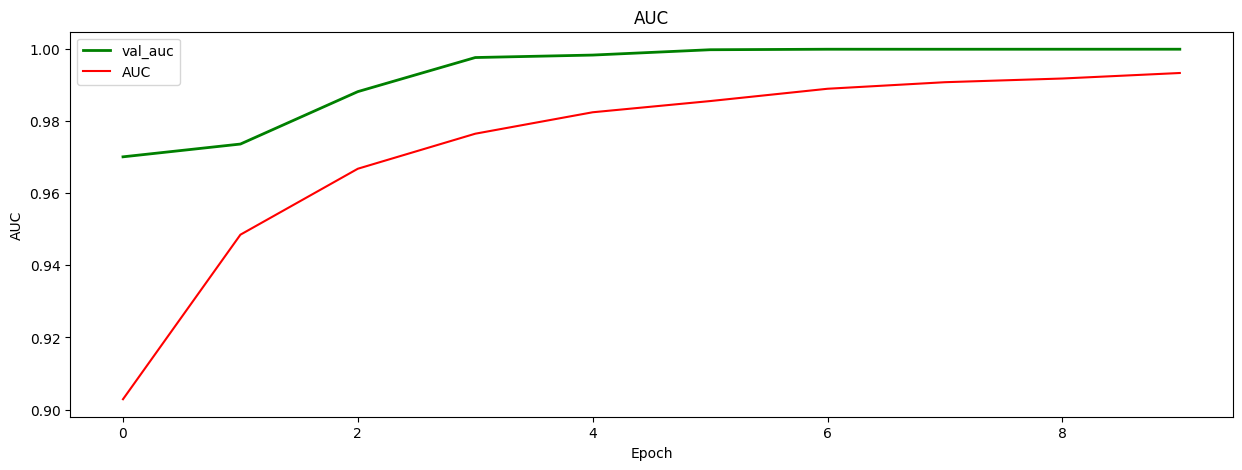

In [60]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_auc'],label='val_auc',color = "green" ,
     linewidth=2, markersize=12)
plt.plot(range(history.epoch[-1]+1),history.history['auc'],label='AUC', color = "red" )
plt.title('AUC'); plt.xlabel('Epoch'); plt.ylabel('AUC');plt.legend();
plt.show()

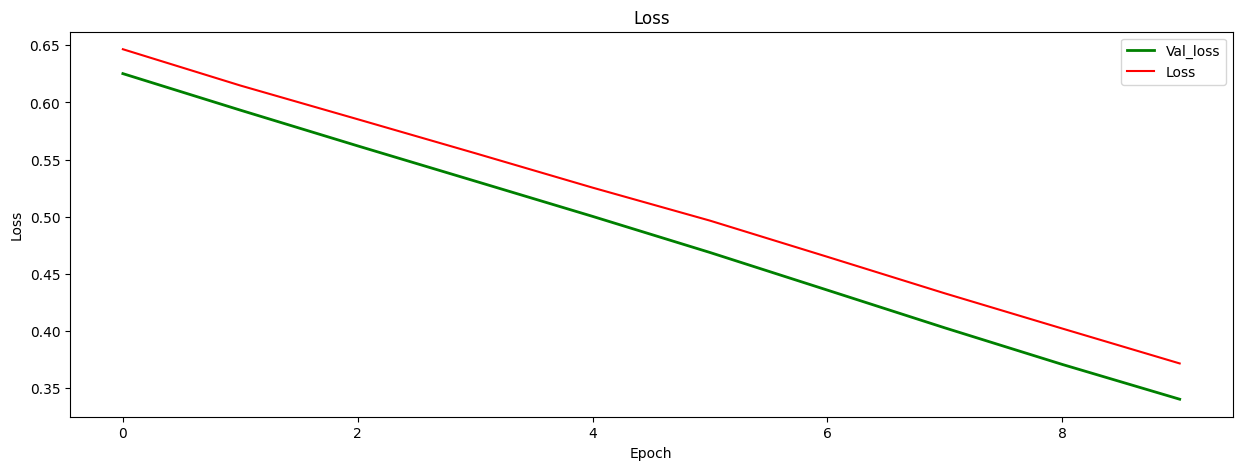

In [57]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss',color = "green" ,
     linewidth=2, markersize=12)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Loss', color = "red")
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss');plt.legend();
plt.show()

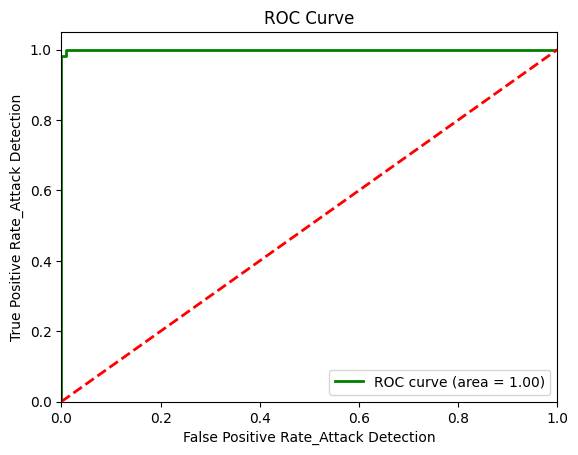

In [58]:
def generate_results(y_test, y_score):
    # print(y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='green',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate_Attack Detection')
    plt.ylabel('True Positive Rate_Attack Detection')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

generate_results(y_test, y_pred)